In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Conv2D, Activation, BatchNormalization,
    UpSampling2D, Input, Concatenate
)
from tensorflow.keras.layers import Dropout, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

from segmentation_stats import (
    continuous_dice_coefficient, continuous_dice_coefficient_loss,
    balanced_average_hausdorff_distance
)

2024-01-17 18:56:34.736310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 18:56:34.736374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 18:56:34.738097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 18:56:34.749168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 18:56:36.349075: W tensorflow/compiler/tf2

In [2]:
tf.keras.backend.clear_session()
tf.config.set_visible_devices([], 'GPU')

2024-01-17 18:56:39.617397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 18:56:39.847179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 18:56:39.847580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [4]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH_SIZE = 2
LR = 1e-4

PATH = "."

# Dataset

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    total_size = len(images)
    valid_size = int(total_size * split)
    test_size = int(total_size * split)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    
    return x

## Building the tf.data pipeline

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y


def tf_dataset(x, y, batch=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  624
Validation data:  78
Testing data:  78


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    return x

# Model

In [10]:
#inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
#encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

In [11]:
#encoder.summary()

In [12]:
#inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
#encoder2 = EfficientNetV2L(input_tensor=inputs, weights='imagenet', include_top=False)

In [13]:
#encoder2.summary()

In [14]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = EfficientNetV2L(input_tensor=inputs, weights="imagenet", include_top=False)
    # skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    skip_connection_names = ["input_image", "block1d_project_activation", "block2g_expand_activation", "block4a_expand_activation", "block6a_expand_activation"]
    encoder_output = encoder.get_layer("top_activation").output
    #skip_connection_names = ["input_image", "re_lu", "re_lu_3", "re_lu_7"]
    #encoder_output = encoder.get_layer("re_lu_16").output

    f = [16, 32, 48, 64, 80]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [15]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_image[0][0]']         
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                           

# Metrics

In [16]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training

In [17]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

In [18]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [continuous_dice_coefficient, balanced_average_hausdorff_distance]
model.compile(loss=continuous_dice_coefficient_loss, optimizer=opt, metrics=metrics)

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [20]:
train_steps = len(train_x) // BATCH_SIZE
valid_steps = len(valid_x) // BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(valid_x) % BATCH_SIZE != 0:
    valid_steps += 1
    
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30


2024-01-17 18:59:57.198282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-01-17 18:59:57.248803: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2024-01-17 18:59:57.250180: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2024-01-17 18:59:57.334896: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82575360 exceeds 10% of free system memory.
2024-01-17 18:59:57.335889: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82575360 exceeds 10% of free system memory.
2024-01-17 19:00:00.316263: I external/local_xla/xla/service/service.cc:168] XLA service 0x5588da5d0900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-17 19:00:00.316314: I external/local_xla/xla/service/service.cc:1

312/312 [==============================] - 1912s 5s/step - loss: 0.7033 - dice_coef: 0.2967 - recall: 0.7957 - precision: 0.3221 - val_loss: 0.7244 - val_dice_coef: 0.2756 - val_recall: 0.6578 - val_precision: 0.4304 - lr: 1.0000e-04
Epoch 2/30
312/312 [==============================] - 1639s 5s/step - loss: 0.5954 - dice_coef: 0.4046 - recall: 0.8210 - precision: 0.5357 - val_loss: 0.8269 - val_dice_coef: 0.1731 - val_recall: 0.1561 - val_precision: 0.6236 - lr: 1.0000e-04
Epoch 3/30
312/312 [==============================] - 1404s 5s/step - loss: 0.5309 - dice_coef: 0.4691 - recall: 0.8267 - precision: 0.6395 - val_loss: 0.8582 - val_dice_coef: 0.1418 - val_recall: 0.0871 - val_precision: 0.8859 - lr: 1.0000e-04
Epoch 4/30
312/312 [==============================] - 1181s 4s/step - loss: 0.4654 - dice_coef: 0.5346 - recall: 0.8292 - precision: 0.7292 - val_loss: 0.7476 - val_dice_coef: 0.2524 - val_recall: 0.2998 - val_precision: 0.7811 - lr: 1.0000e-04
Epoch 5/30
312/312 [===========

In [21]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = len(test_x) // BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

39/39 [==============================] - 33s 853ms/step - loss: 0.4304 - dice_coef: 0.5696 - recall: 0.6348 - precision: 0.7358


[0.43037477135658264,
 0.5696252584457397,
 0.6347893476486206,
 0.7357689738273621]

# Results

In [22]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [23]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 1s 511ms/step


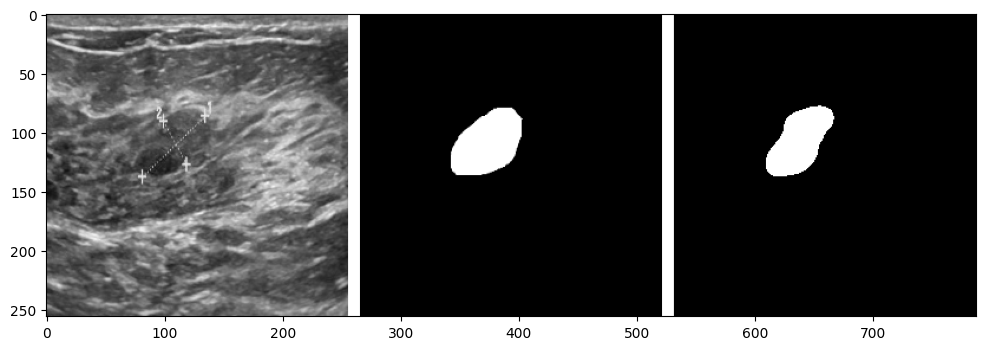

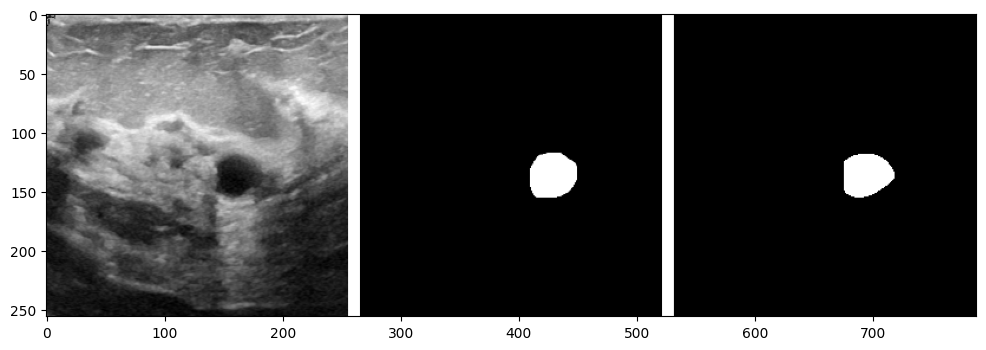

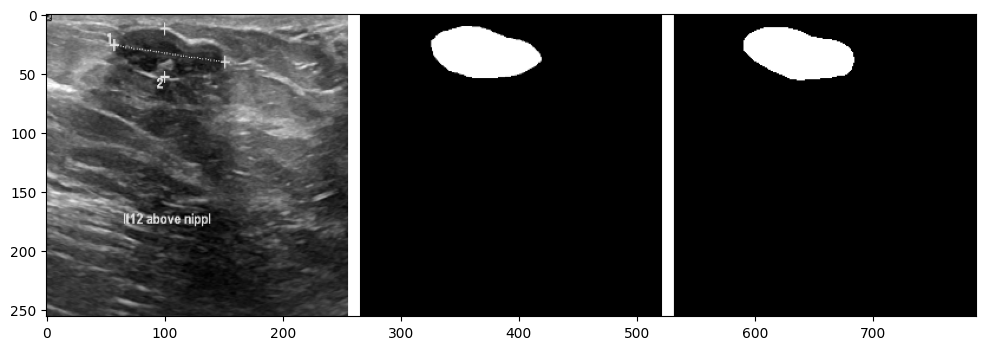

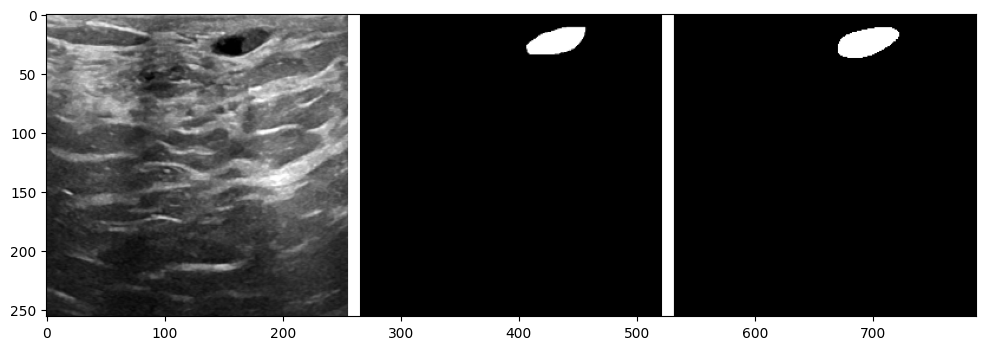

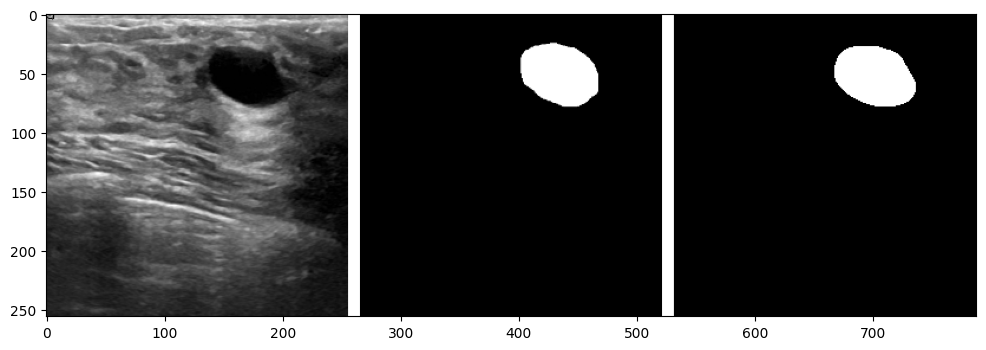

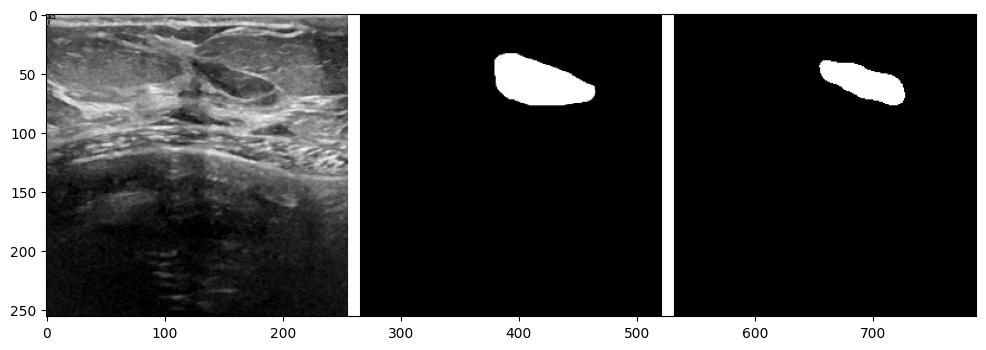

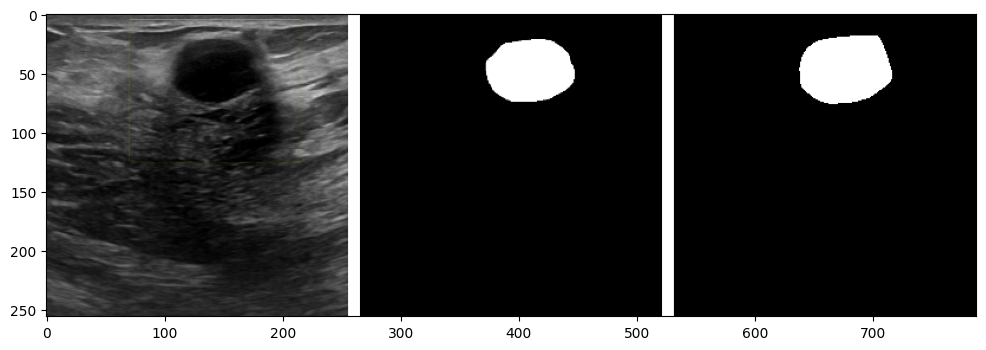

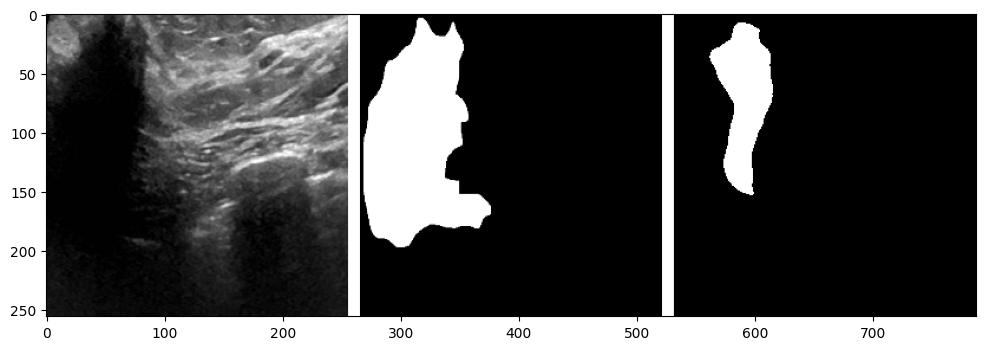

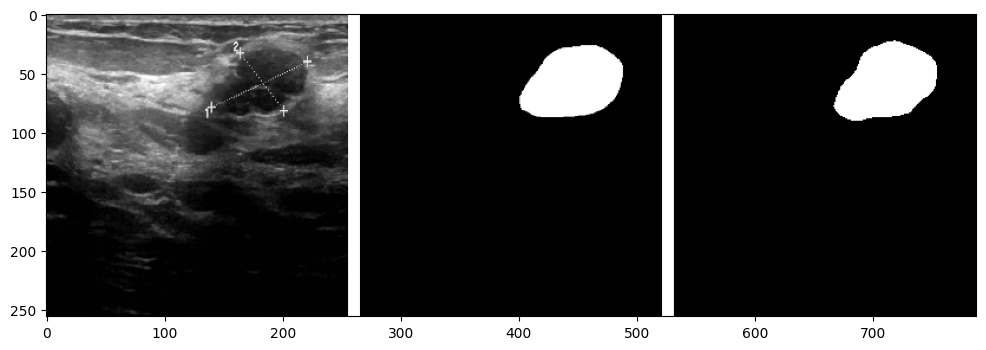

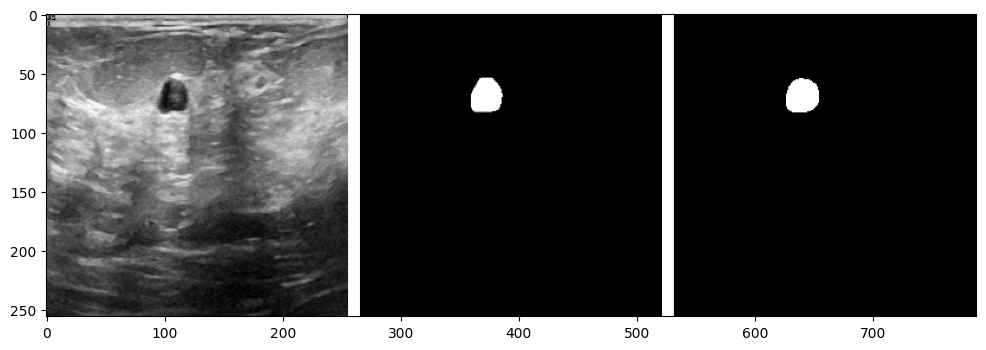

In [24]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)